In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from  multimodemodel import (
    StaggeredGrid,
    State,
    Variable,
    Parameters,
    integrate,
    adams_bashforth3,
    pressure_gradient_i,
    pressure_gradient_j,
    divergence_i,
    divergence_j,
)
from multimodemodel.API_implementation import (
    DomainState,
    GeneralSolver,
    RegularSplitMerger,
    BorderState,
    BorderMerger,
    Tail,
)
from dask.distributed import Client

/Users/mclaus/mambaforge/envs/test_mm_distributed/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
client = Client(n_workers=4, threads_per_worker=4)
# client

In [3]:
def staggered_grid(shape, grid_spacing):
    nx, ny = shape
    dx, dy = grid_spacing
    x = np.arange(0.0, dx * nx, dx)
    y = np.arange(0.0, dy * ny, dy)
    return StaggeredGrid.cartesian_c_grid(x, y)

In [4]:
nx, ny = 100, 100
dx, dy = 1., 1.
n_step = 500

parameter = Parameters(H=1.0)

grid = staggered_grid((nx, ny), (dx, dy))

In [5]:
def initial_condition(staggered_grid, parameter):
    nx, ny = staggered_grid.u.len_x, staggered_grid.u.len_y
    u = np.zeros((nx, ny))
    v = np.zeros((nx, ny))
    x, y = staggered_grid.eta.x, staggered_grid.eta.y
    eta = np.exp(
        -((x - x.mean()) ** 2 + (y - y.mean()) ** 2)
        / (x.max() // 5) ** 2
    )

    initial_state = State(
        u=Variable(u, staggered_grid.u),
        v=Variable(v, staggered_grid.v),
        eta=Variable(eta, staggered_grid.eta),
    )

    return DomainState.make_from_State(
        initial_state, history=deque([], maxlen=3), parameter=parameter, it=0, id=0
    )


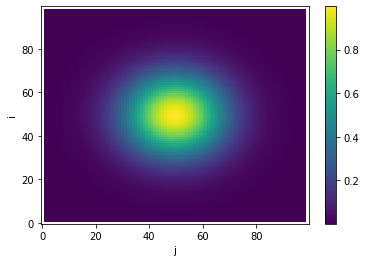

In [6]:
initial_condition(grid, parameter).eta.as_dataarray.plot()

In [7]:
def non_rotating_swe(state, params):
    rhs = (
        pressure_gradient_i(state, params)
        + pressure_gradient_j(state, params)
        + divergence_i(state, params)
        + divergence_j(state, params)
    )
    return rhs

In [8]:
def get_dt(grid, parameter):
    dx = min(grid.dx.min(), grid.dy.min())
    c = np.sqrt(parameter.H * parameter.g)
    return 0.15 * dx / c

In [9]:
def classic_API(initial_state, dt):
    state = State(initial_state.u, initial_state.v, initial_state.eta)
    for next_state in integrate(
        state,
        initial_state.parameter,
        RHS=non_rotating_swe,
        step=dt,
        time=n_step * dt,
        scheme=adams_bashforth3,
    ):
        pass
    return next_state

In [10]:
def new_API_without_split(initial_state, dt):
    gs = GeneralSolver(
        solution=non_rotating_swe,
        schema=adams_bashforth3,
        step=dt
    )
    next = initial_state
    for _ in range(n_step):
        next = gs.integration(next)
    return next

In [11]:
def new_API_with_split_no_dask(initial_state, dt, parts=4):
    border_width = 2
    dim = (0,)
    splitter = RegularSplitMerger(parts, dim)
    border_merger = BorderMerger(border_width, dim[0])
    tailor = Tail()
    gs = GeneralSolver(
        solution=non_rotating_swe,
        schema=adams_bashforth3,
        step=dt
    )

    domain_stack = deque([tailor.split_domain(initial_state, splitter)], maxlen=2)
    border_stack = deque(
        [[tailor.make_borders(sub, border_width, dim[0]) for sub in domain_stack[-1]]],
        maxlen=2,
    )
    for _ in range(n_step):
        new_borders = []
        new_subdomains = []
        for i, s in enumerate(domain_stack[-1]):
            new_borders.append(
                (
                    gs.partial_integration(
                        border=border_stack[-1][i][0],
                        domain=s,
                        neighbor_border=border_stack[-1][i - 1][1],
                        direction=False,
                        dim=dim[0],
                    ),
                    gs.partial_integration(
                        border=border_stack[-1][i][1],
                        domain=s,
                        neighbor_border=border_stack[-1][(i + 1) % (splitter.parts)][0],
                        direction=True,
                        dim=dim[0],
                    ),
                )
            )
        for s, borders in zip(domain_stack[-1], new_borders):
            new_subdomains.append(
                DomainState.merge(
                    (borders[0], gs.integration(s), borders[1]), border_merger
                )
            )
        domain_stack.append(new_subdomains)
        border_stack.append(new_borders)

    return DomainState.merge(domain_stack[-1], splitter)


In [12]:
def _make_borders(base, width, dim, client):
    return (
        client.submit(
            BorderState.create_border,
            base, width, False, dim,
        ),
        client.submit(
            BorderState.create_border,
            base, width, True, dim,
        ),
    )

def new_API_with_split_and_dask(initial_state, dt, client, parts=4):
    border_width = 2
    dim = (1,)
    splitter = RegularSplitMerger(parts, dim)
    border_merger = BorderMerger(border_width, dim[0])
    tailor = Tail()
    gs = GeneralSolver(
        solution=non_rotating_swe,
        schema=adams_bashforth3,
        step=dt
    )

    domain_stack = deque([client.scatter(initial_state.split(splitter))], maxlen=2)
    border_stack = deque(
        [[_make_borders(sub, border_width, dim[0], client) for sub in domain_stack[-1]]],
        maxlen=2,
    )
    for _ in range(n_step):
        new_borders = []
        new_subdomains = []
        for i, s in enumerate(domain_stack[-1]):
            new_borders.append(
                (
                    client.submit(
                        gs.partial_integration,
                        border=border_stack[-1][i][0],
                        domain=s,
                        neighbor_border=border_stack[-1][i - 1][1],
                        direction=False,
                        dim=dim[0],
                    ),
                    client.submit(
                        gs.partial_integration,
                        border=border_stack[-1][i][1],
                        domain=s,
                        neighbor_border=border_stack[-1][(i + 1) % (splitter.parts)][0],
                        direction=True,
                        dim=dim[0],
                    ),
                )
            )
        for s, borders in zip(domain_stack[-1], new_borders):
            new_subdomains.append(
                client.submit(
                    DomainState.merge,
                    (borders[0], client.submit(gs.integration, s), borders[1]),
                    border_merger,
                )
            )
        domain_stack.append(new_subdomains)
        border_stack.append(new_borders)

    return DomainState.merge(client.gather(domain_stack[-1]), splitter)

In [13]:
def new_API_with_split_by_term_and_dask(initial_state, dt, client):

    def non_rotating_swe_with_dask(state):
        terms = [client.submit(f, state, client.submit(getattr, state, "parameter")) for f in (pressure_gradient_i, pressure_gradient_j, divergence_i, divergence_j)]
        rhs = client.submit(sum, terms[1:], terms[0])
        return rhs
    
    def append_to_history(domain_future, inc):
        domain_future.history.append(inc)
        return domain_future 

    def timestep(old):
        new = adams_bashforth3(old.history, old.parameter, dt)
        return DomainState(
            old.u + new.u,
            old.v + new.v,
            old.eta + new.eta,
            old.history,
            old.parameter,
            old.increment_iteration(),
            old.get_id(),
        )
    
    def integration(domain: DomainState) -> DomainState:
        inc = non_rotating_swe_with_dask(domain)
        domain_with_inc = client.submit(append_to_history, domain, inc)
        return client.submit(timestep, domain_with_inc)

    next = client.scatter(initial_state, broadcast=True)
    for _ in range(n_step):
        next = integration(next)
    return next.result()

In [14]:
# numba warm up
oracle = classic_API(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter)
)

In [15]:
%%time
oracle = classic_API(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter)
)

CPU times: user 222 ms, sys: 18.3 ms, total: 240 ms
Wall time: 238 ms


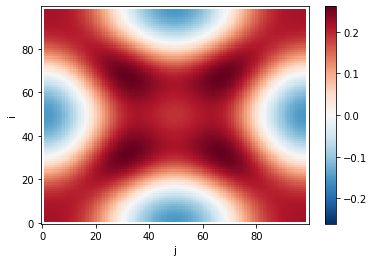

In [16]:
oracle.eta.as_dataarray.plot()

In [17]:
%%time
new_wo_split = new_API_without_split(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter),
)

CPU times: user 442 ms, sys: 24.5 ms, total: 466 ms
Wall time: 297 ms


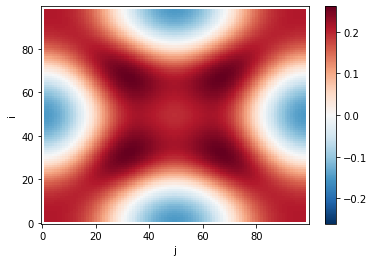

In [18]:
new_wo_split.eta.as_dataarray.plot()

In [19]:
%%time
new_with_split_no_dask = new_API_with_split_no_dask(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter),
    parts=4
)

CPU times: user 3.71 s, sys: 257 ms, total: 3.97 s
Wall time: 3.74 s


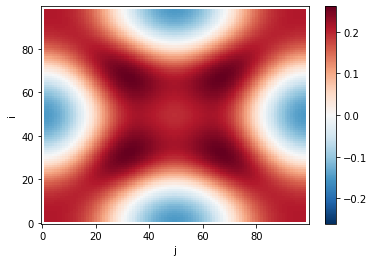

In [20]:
new_with_split_no_dask.eta.as_dataarray.plot()

In [21]:
%%time
new_with_split_and_dask = new_API_with_split_and_dask(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter),
    client
)

/Users/mclaus/mambaforge/envs/test_mm_distributed/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


CPU times: user 39.1 s, sys: 1.63 s, total: 40.7 s
Wall time: 45.8 s


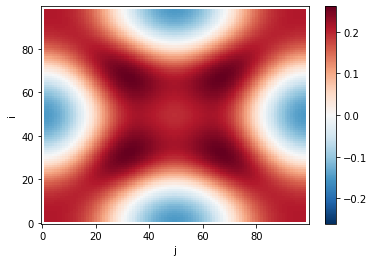

In [22]:
new_with_split_and_dask.eta.as_dataarray.plot()

In [23]:
%%time
new_with_split_by_term_and_dask = new_API_with_split_by_term_and_dask(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter),
    client
)

/Users/mclaus/mambaforge/envs/test_mm_distributed/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)
/Users/mclaus/mambaforge/envs/test_mm_distributed/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)
/Users/mclaus/mambaforge/envs/test_mm_distributed/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


CPU times: user 23.2 s, sys: 1.63 s, total: 24.8 s
Wall time: 35.8 s


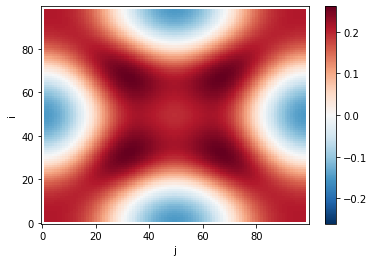

In [24]:
new_with_split_by_term_and_dask.eta.as_dataarray.plot()